In [1]:
import json
import pickle
import importlib
import utils
import matplotlib.pyplot as plt

importlib.reload(utils)

<module 'utils' from '/home/benh/school/06spring2021/322CPSC/spotify-popularity-project/utils.py'>

# Spotify Popularity Predictor
The goal of this project is for a user to be able to lookup a song on Spotify and receive a prediction of how popular it is. Originally, we had intended to predict the number of playlists that a song occurred on, but we opted to switch to popularity in order to make the possible unseen values be the entirity of Spotify's library.

## Part 1: The Dataset
Our dataset is composed of over 2 million songs from spotify that we got from a variety of sources. Currently, each entry contains 10 attributes, one of which is the predicted attribute. These attributes include:
- Number of Artists
    - With Hip Hop being the dominant force in music right now, and features being a huge part of Hip Hop, it makes sense to take the number of
    features into account 
- The Primary Artist for the track
    - While not inherently useful for models other than Naive Bayes, we can
    use the spotify api to get more data about each track like genre and
    artist popularity. Genre in particular would be very useful, but since
    Spotify attaches multiple to each artist, it will complicate the training
    process. There are only ~300k unique artists so getting this information
    would be trivial
- Release Year
    - Obviously different years are going to have different sorts of performing songs, and things that make an older song popular don't neccessariliy translate
- Duration
    - For a song to become popular, it had to be no more than 3 minutes back in the day. That trend has continued and the duration of a
    song still affects its popularity
- Explicit
    - It is hard to say how useful this will be, though it will will be useful alongside genre in a decision tree
- Danceability
    - This is a metric calculated by Spotify for its recommendation system,
    but it will probably be quite useful for us
- Energy
    - Much like Danceability, this one is a calculation by Spotify for their 
    recommendation system and will likely be useful. Both of these would     
    likely be enhanced by adding genre to the mix
- Tempo
    - The tempo of the song in Beats per Minute. Historically this has been
    a good predictor of how much a song gets played on the radio or in a 
    club
- Loudness
    - This appears to be the peak volume of the track. Another one that would
    be enhanced by genre
- Time Signature
    - The the number of counts per measure. This will likely help filter out
    less popular forms of music such as math rock, free jazz, etc. Songs with
    more complex time signatures are usually less popular. 3/4
- Popularity
    - The attribute we are predicting for. This is a value in the range \[0,100\]
    that has to do with the number of plays and how recent they were. An artist's
    top 10 tracks are shown based on this value. Unfortunately, the total number
    of plays is not exposed to the API.

### Getting the Dataset
As mentioned, we originally planned on using the million playlists dataset from spotify to factor in the number of
times a track appears on a playlist, but this would have severely limited the unseen instances we could use. The dataset
did include over 2 million unique songs though, so we opted to use that as the basis for our dataset. After getting the list
of songs, we then needed to query the Spotify Web API for those attributes listed above. The ended up being around 69,000
requests and took about 4 hours. Thankfully the API allowed us to query data for multiple songs at a time, which is why there
wasn't 4 million requests. Each instance contains info from both the `tracks` endpoint and the `audio-features` endpoint. The
`tracks` endpoint takes 50 songs per request, and the `audio-features` endpoint takes 100. Interestingly, more than 70% of
the time spent was retrieving the `audio-features` data, despite it making up only ~23,000 of the requests. That means that
each request took nearly 5 times as long to complete as the `tracks` requests (~7ms per request compared to ~1.5ms). I'm not
sure what caused this, but my best theory is that endpoints are prioritized by usage. Logically the `tracks`, `artists`, and 
`playlists` endpoints would be the most used and thus have the highest priority in whatever queuing. I considered rate limiting,
but as I had several of these requests literally time out, I think that this is a much more reasonable explination, as Spotify
sends a 429 with a `Retry-After` header when you perform too many requests.

### Minor Pre-processing note
We removed all values with a time signature of 1 or 0, and cast all release years to ints

### Example Instance
Here is an example instance from the dataset. Attributes are in the order
they appear above.

```{.json}
{
    ...,
    "0UaMYEvWZi0ZqiDOoHU3YI": [
        3,
        "2wIVse2owClT7go1WT98tk",
        2005,
        226863,
        true,
        0.904,
        0.813,
        125.461,
        -7.105,
        4,
        68
    ],
    ...
}
```

## Part 2: Initial Dataset Analysis
To kick of the analysis of our dataset, we wanted to better understand each of our attributes. For
the continuous attributes, we created histograms, and for the other 2, explicit and artist, we looked it frequency and
number of unique values respectively

In [2]:
# load the data
with open('./data/slices/slice01.pickle', 'rb') as fp:
    song_data, labels = pickle.load(fp)

# get the attribute info
cols = utils.generate_columns(song_data, labels)

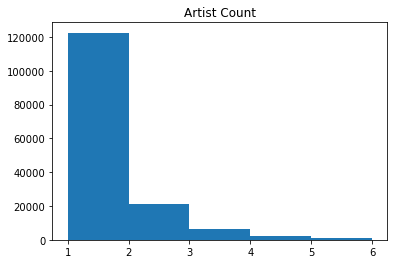

In [4]:
# Number of Artists/featured artists

plt.figure()
plt.title("Artist Count")
plt.hist(cols["artists_count"], bins=5, range=(1,6))
plt.show()

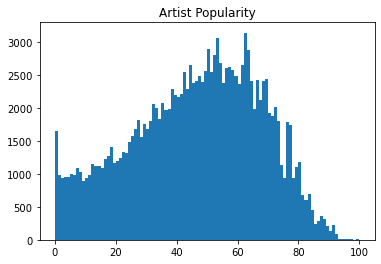

In [5]:
# Artist popularity

plt.figure()
plt.title("Artist Popularity")
plt.hist(cols["artist_popularity"], bins=range(101))
plt.show()

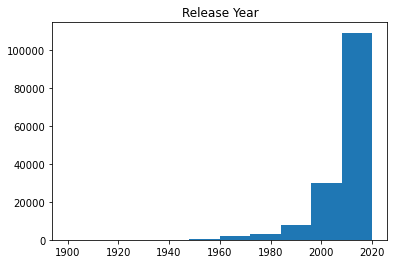

In [6]:
# Release Year

plt.figure()
plt.title("Release Year")
plt.hist(cols["release_year"], range=(1900, 2020))
plt.show()


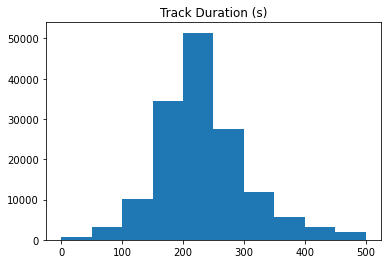

In [7]:
# Song Length (ms)
plt.figure()
plt.title("Track Duration (s)")
plt.hist(cols["duration"], range=(0, 500))
plt.show()

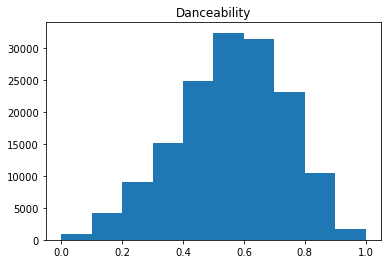

In [8]:
# Dancibility

plt.figure()
plt.title("Danceability")
plt.hist(cols["danceability"], bins=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))
plt.show()

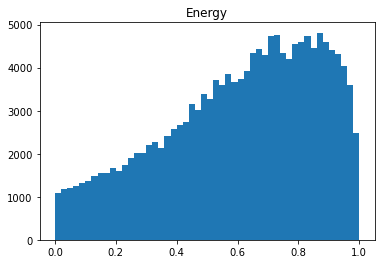

In [9]:
# Energy

plt.figure()
plt.title("Energy")
#plt.hist(cols["energy"], bins=(0,0.3,0.5,0.65,0.8,0.9,1))
plt.hist(cols["energy"], bins=50)
plt.show()


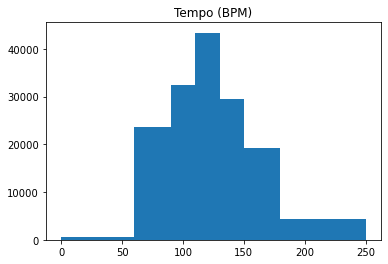

In [10]:
# Tempo

plt.figure()
plt.title("Tempo (BPM)")
plt.hist(cols["tempo"], bins=(0,60,90,110,130,150,180,250))
plt.show()


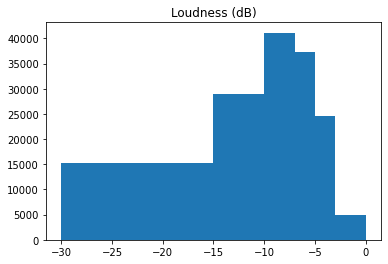

In [11]:
# Loudness

plt.figure()
plt.title("Loudness (dB)")
plt.hist(cols["loudness"], bins=(-30,-15,-10,-7,-5,-3,0))
plt.show()

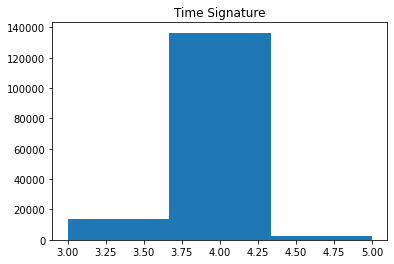

In [12]:
# Time

plt.figure()
plt.title("Time Signature")
plt.hist(cols["time_signature"], bins=3)
plt.show()

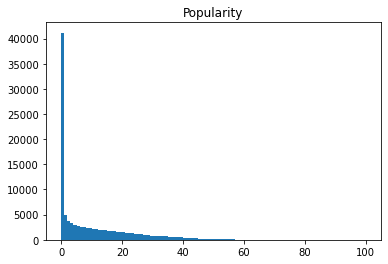

In [3]:
# Popularity

plt.figure()
plt.title("Popularity")
plt.hist(cols["popularity"], bins=range(101))
plt.show()

In [15]:
# Explicit

explicit_freq = utils.get_frequency(cols["explicit"])
print("Number of clean songs: ", explicit_freq[False], ", ", round((100 * explicit_freq[False] / len(song_data)), 1), "%", sep='')
print("Number of explicit songs: ", explicit_freq[True], ", ", round((100 * explicit_freq[True] / len(song_data)), 1), "%", sep='')


Number of clean songs: 137187, 89.7%
Number of explicit songs: 15744, 10.3%


### Conclusions
So, the big convlusion we came to when making this is that more filtering needs to be done. There are consistant outliers in most columns, which somewhat hurts our data. We also would probably be served by generating a validation set from songs outside this dataset to prevent
overtraining. It's hard to say how they generated their playlist dataset, so it may be best
to take matters into our own hands.

We also will almost certainly need to split up the dataset a bit. The Jupyter kernal is currently using about 3.0GB of memory, which is not very laptop friendly.